# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
import os
import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Useful

In [3]:
def check_shape_head(df : pd.DataFrame):
    assert isinstance(df, pd.DataFrame), f"{df} sould be a pandas dataframe"
    print(df.shape)
    return df.head(2)

# Retrieve data

In [4]:
# take environment variables from .env.
# load_dotenv()

In [5]:
data_path = os.getenv("DATA_HR")

In [6]:
#Retrieve dataset from local directory
dataset = pd.read_csv(data_path)

In [7]:
pd.set_option('display.max_columns', None)
check_shape_head(dataset)

(14999, 62)


,ID,Name,Department,GEO,Role,Rising_Star,Will_Relocate,Critical,Trending Perf,Talent_Level,Validated_Talent_Level,Percent_Remote,EMP_Sat_OnPrem_1,EMP_Sat_OnPrem_2,EMP_Sat_OnPrem_3,EMP_Sat_OnPrem_4,EMP_Sat_OnPrem_5,EMP_Sat_Remote_1,EMP_Sat_Remote_2,EMP_Sat_Remote_3,EMP_Sat_Remote_4,EMP_Sat_Remote_5,EMP_Engagement_1,EMP_Engagement_2,EMP_Engagement_3,EMP_Engagement_4,EMP_Engagement_5,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left_Company,CSR Factor,promotion_last_5years,sales,salary,Gender,LinkedIn_Hits,Emp_Work_Status2,Emp_Work_Status_3,Emp_Work_Status_4,Emp_Work_Status_5,Emp_Identity,Emp_Role,Emp_Position,Emp_Title,Women_Leave,Men_Leave,Emp_Competitive_1,Emp_Competitive_2,Emp_Competitive_3,Emp_Competitive_4,Emp_Competitive_5,Emp_Collaborative_1,Emp_Collaborative_2,Emp_Collaborative_3,Emp_Collaborative_4,Emp_Collaborative_5,Sensor_StepCount,Sensor_Heartbeat(Average/Min),Sensor_Proximity(1-highest/10-lowest)
0,1,BRADDY,Operations,US,VP,NaN,0,1.0,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,3,168,3,1,0,NaN,0,sales,low,M,5,4,3,1,1,1,1,2,1,NaN,1.0,2,4,2,2,2,2,2,2,1,5,1841,61,9
1,2,BORST,Sales,UK,Senior Director,NaN,0,NaN,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,5,159,2,0,0,NaN,0,accounting,low,F,58,3,3,4,3,2,1,2,1,0.0,NaN,2,2,1,4,1,3,2,5,1,5,1990,90,8


# Data preparation

In [8]:
# Remove unwanted columns
dataset.drop(columns = ['ID','Name','Rising_Star', 'Trending Perf', 'Talent_Level',
                     'Validated_Talent_Level', 'EMP_Sat_OnPrem_1', 'EMP_Sat_OnPrem_2',
                     'EMP_Sat_OnPrem_3','EMP_Sat_Remote_3', 'EMP_Sat_Remote_4','EMP_Sat_Remote_5',
                     'EMP_Engagement_2','EMP_Engagement_3','EMP_Engagement_4',
                     'EMP_Engagement_5','CSR Factor','sales'], inplace = True)

check_shape_head(dataset)

(14999, 44)


,Department,GEO,Role,Will_Relocate,Critical,Percent_Remote,EMP_Sat_OnPrem_4,EMP_Sat_OnPrem_5,EMP_Sat_Remote_1,EMP_Sat_Remote_2,EMP_Engagement_1,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left_Company,promotion_last_5years,salary,Gender,LinkedIn_Hits,Emp_Work_Status2,Emp_Work_Status_3,Emp_Work_Status_4,Emp_Work_Status_5,Emp_Identity,Emp_Role,Emp_Position,Emp_Title,Women_Leave,Men_Leave,Emp_Competitive_1,Emp_Competitive_2,Emp_Competitive_3,Emp_Competitive_4,Emp_Competitive_5,Emp_Collaborative_1,Emp_Collaborative_2,Emp_Collaborative_3,Emp_Collaborative_4,Emp_Collaborative_5,Sensor_StepCount,Sensor_Heartbeat(Average/Min),Sensor_Proximity(1-highest/10-lowest)
0,Operations,US,VP,0,1.0,0.4,3.0,5.0,2,3,5,0.36,3,168,3,1,0,0,low,M,5,4,3,1,1,1,1,2,1,NaN,1.0,2,4,2,2,2,2,2,2,1,5,1841,61,9
1,Sales,UK,Senior Director,0,NaN,0.4,3.0,5.0,2,3,5,0.36,5,159,2,0,0,0,low,F,58,3,3,4,3,2,1,2,1,0.0,NaN,2,2,1,4,1,3,2,5,1,5,1990,90,8


In [9]:
# Rename columns
dataset = dataset.rename(columns={
                                    'Sensor_Heartbeat(Average/Min)': 'Sensor_Heartbeat',
                                    'Sensor_Proximity(1-highest/10-lowest)': 'Sensor_Proximity'
                                })
# check_shape_head(dataset)

In [10]:
# Convert column names to lower snake case
dataset.columns = dataset.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '_')
# check_shape_head(dataset)

# General prerequisities

In [11]:
# checking missing values
dataset.isnull().sum().sort_values(ascending=False);

In [12]:
# impute binary missing values for critical column
dataset.loc[dataset['critical'].isna(), 'critical'] = 0

In [13]:
# covert gender column into binary classification column
dataset['gender'] = dataset['gender'].map({'F': 1, 'M': 0})

In [14]:
# impute missing values with mode as these are ranking/ordinal columns
columns_to_impute = ['emp_sat_onprem_4', 'emp_sat_onprem_5']
imputer = SimpleImputer(strategy='most_frequent')
dataset[columns_to_impute] = imputer.fit_transform(dataset[columns_to_impute])

In [15]:
# target imbalancing
# the target is imbalanced, however we aim to predict those consumers who will be retained within the company,
# and this is 76% of the data, so we rebalancing is necessary.

dataset['left_company'].value_counts(normalize = True)

left_company
0    0.761917
1    0.238083
Name: proportion, dtype: float64

# Numerical Features Data Cleaning ONLY

/tmp/ipykernel_63540/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset[column], palette='Set2')
/tmp/ipykernel_63540/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset[column], palette='Set2')
/tmp/ipykernel_63540/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset[column], palette='Set2')
/tmp/ipykernel_63540/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `l

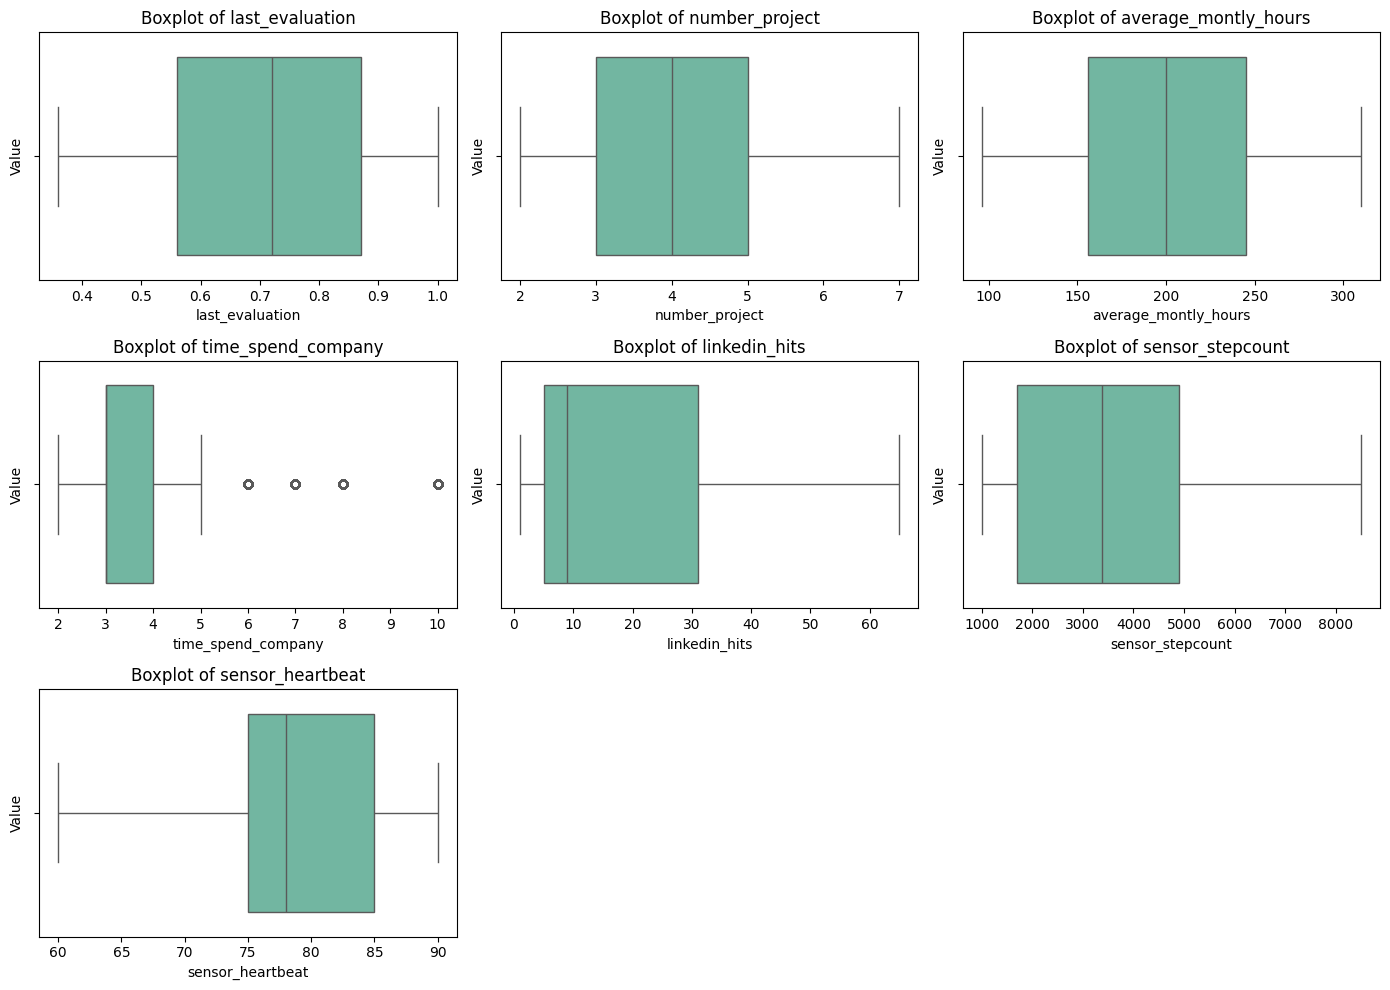

In [16]:
# detecting outliers with numerical columns only

numerical_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'time_spend_company', 'linkedin_hits', 'sensor_stepcount',
                     'sensor_heartbeat']

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=dataset[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [17]:
# time_spend_company is the only numeric variable with outliers therefore we will use the Robust Scaler.
rb_scaler = RobustScaler()
dataset['time_spend_company'] = rb_scaler.fit_transform(dataset[['time_spend_company']])

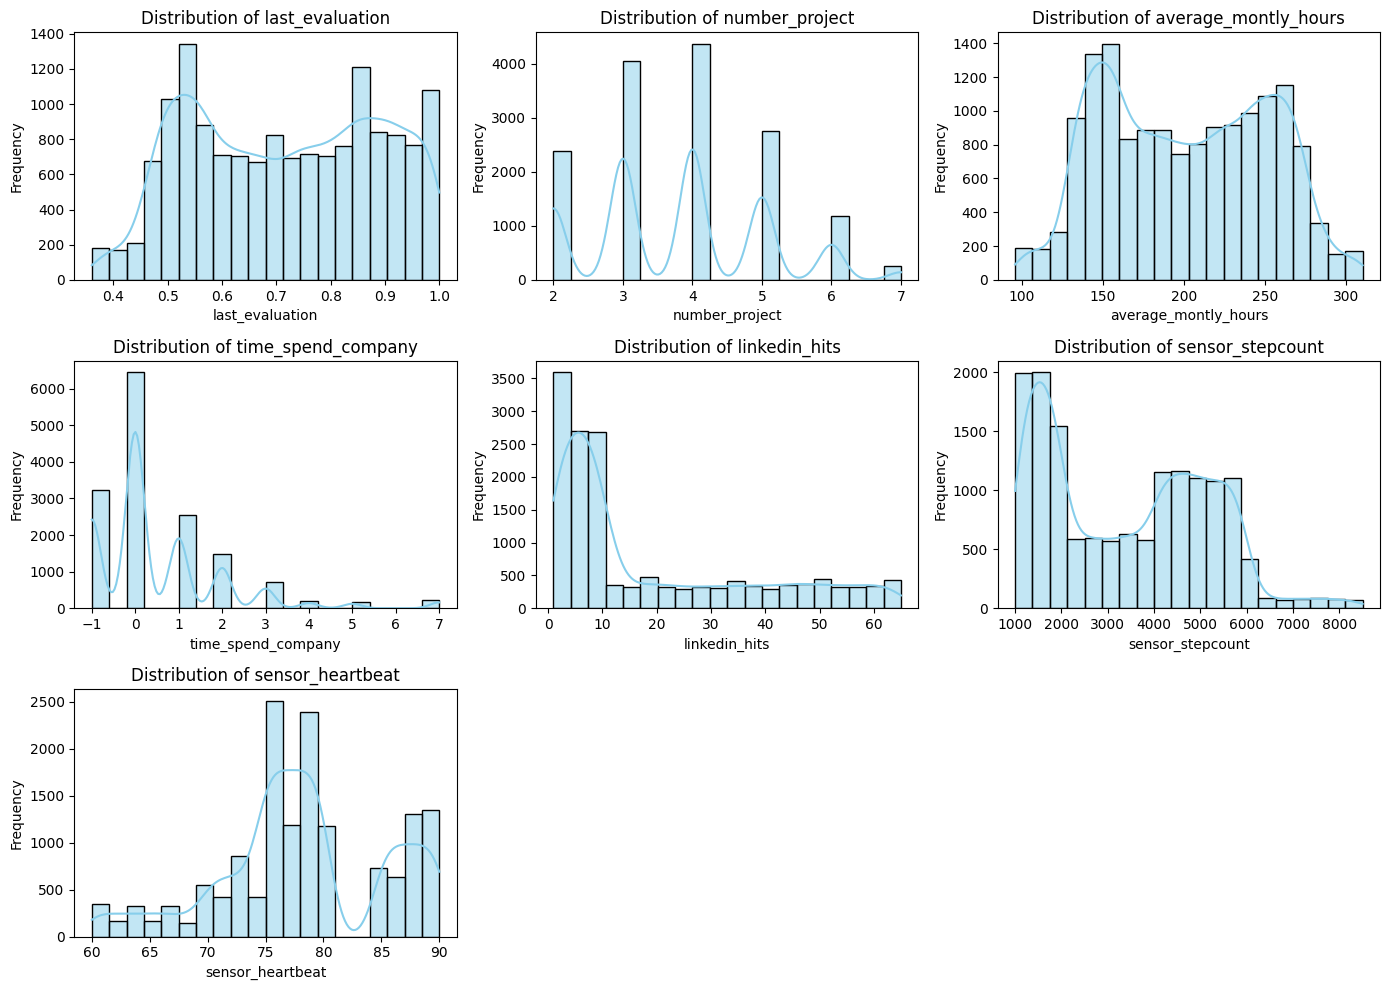

In [18]:
# plot the distributions of the numerical features to determine which scalers to use
# none of the plots seems to be normally distributed so the MinMaxScaling is chosen

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(dataset[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [19]:
# for all other numerical variables, use the minmaxscaler
minmaxscaler_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'linkedin_hits', 'sensor_stepcount', 'sensor_heartbeat']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
dataset[minmaxscaler_columns] = scaler.fit_transform(dataset[minmaxscaler_columns])

# Categorical Features ONLY Feature Engineering

In [20]:
# ordinal encoding for salary
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(dataset[['salary']])
print(ordinal_encoder.categories_)
dataset['encoded_salary'] = ordinal_encoder.transform(dataset[['salary']]) # 1 = low, 2 = medium, 3 = high
dataset.drop(columns = ['salary'], inplace = True)

[array(['high', 'low', 'medium'], dtype=object)]


In [21]:
# OneHotEncoding for department, geo and role
ohe_columns = ['department', 'geo', 'role']
ohe = OneHotEncoder(sparse_output = False)
ohe_data = ohe.fit_transform(dataset[ohe_columns])

ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))
encoded_dataset = pd.concat([dataset, ohe_df], axis=1)
encoded_dataset.drop(columns = ['department', 'geo', 'role'], inplace = True)

In [22]:
check_shape_head(encoded_dataset)

(14999, 63)


,will_relocate,critical,percent_remote,emp_sat_onprem_4,emp_sat_onprem_5,emp_sat_remote_1,emp_sat_remote_2,emp_engagement_1,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left_company,promotion_last_5years,gender,linkedin_hits,emp_work_status2,emp_work_status_3,emp_work_status_4,emp_work_status_5,emp_identity,emp_role,emp_position,emp_title,women_leave,men_leave,emp_competitive_1,emp_competitive_2,emp_competitive_3,emp_competitive_4,emp_competitive_5,emp_collaborative_1,emp_collaborative_2,emp_collaborative_3,emp_collaborative_4,emp_collaborative_5,sensor_stepcount,sensor_heartbeat,sensor_proximity,encoded_salary,department_Finance,department_Human Resources,department_IT,department_Operations,department_Sales,department_Warehouse,geo_Australia,geo_China,geo_Colombia,geo_France,geo_Japan,geo_Korea,geo_Turkey,geo_UK,geo_US,role_Director,role_Level 1,role_Level 2-4,role_Manager,role_Senior Director,role_Senior Manager,role_VP
0,0,1.0,0.4,3.0,5.0,2,3,5,0.0,0.2,0.336449,0.0,1,0,0,0,0.062500,4,3,1,1,1,1,2,1,NaN,1.0,2,4,2,2,2,2,2,2,1,5,0.112133,0.033333,9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,0.4,3.0,5.0,2,3,5,0.0,0.6,0.294393,-1.0,0,0,0,1,0.890625,3,3,4,3,2,1,2,1,0.0,NaN,2,2,1,4,1,3,2,5,1,5,0.132000,1.000000,8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Assumption : drop Women_Leave and Men_Leave columns

In [23]:
# Need to decide together.
encoded_dataset.drop(columns = ['women_leave', 'men_leave'], inplace = True)

check_shape_head(encoded_dataset)

(14999, 61)


,will_relocate,critical,percent_remote,emp_sat_onprem_4,emp_sat_onprem_5,emp_sat_remote_1,emp_sat_remote_2,emp_engagement_1,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left_company,promotion_last_5years,gender,linkedin_hits,emp_work_status2,emp_work_status_3,emp_work_status_4,emp_work_status_5,emp_identity,emp_role,emp_position,emp_title,emp_competitive_1,emp_competitive_2,emp_competitive_3,emp_competitive_4,emp_competitive_5,emp_collaborative_1,emp_collaborative_2,emp_collaborative_3,emp_collaborative_4,emp_collaborative_5,sensor_stepcount,sensor_heartbeat,sensor_proximity,encoded_salary,department_Finance,department_Human Resources,department_IT,department_Operations,department_Sales,department_Warehouse,geo_Australia,geo_China,geo_Colombia,geo_France,geo_Japan,geo_Korea,geo_Turkey,geo_UK,geo_US,role_Director,role_Level 1,role_Level 2-4,role_Manager,role_Senior Director,role_Senior Manager,role_VP
0,0,1.0,0.4,3.0,5.0,2,3,5,0.0,0.2,0.336449,0.0,1,0,0,0,0.062500,4,3,1,1,1,1,2,1,2,4,2,2,2,2,2,2,1,5,0.112133,0.033333,9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,0.4,3.0,5.0,2,3,5,0.0,0.6,0.294393,-1.0,0,0,0,1,0.890625,3,3,4,3,2,1,2,1,2,2,1,4,1,3,2,5,1,5,0.132000,1.000000,8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Define X (features)

In [28]:
#Features
X = encoded_dataset.drop(columns=['left_company'])
check_shape_head(X)

(14999, 60)


,will_relocate,critical,percent_remote,emp_sat_onprem_4,emp_sat_onprem_5,emp_sat_remote_1,emp_sat_remote_2,emp_engagement_1,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,gender,linkedin_hits,emp_work_status2,emp_work_status_3,emp_work_status_4,emp_work_status_5,emp_identity,emp_role,emp_position,emp_title,emp_competitive_1,emp_competitive_2,emp_competitive_3,emp_competitive_4,emp_competitive_5,emp_collaborative_1,emp_collaborative_2,emp_collaborative_3,emp_collaborative_4,emp_collaborative_5,sensor_stepcount,sensor_heartbeat,sensor_proximity,encoded_salary,department_Finance,department_Human Resources,department_IT,department_Operations,department_Sales,department_Warehouse,geo_Australia,geo_China,geo_Colombia,geo_France,geo_Japan,geo_Korea,geo_Turkey,geo_UK,geo_US,role_Director,role_Level 1,role_Level 2-4,role_Manager,role_Senior Director,role_Senior Manager,role_VP
0,0,1.0,0.4,3.0,5.0,2,3,5,0.0,0.2,0.336449,0.0,1,0,0,0.062500,4,3,1,1,1,1,2,1,2,4,2,2,2,2,2,2,1,5,0.112133,0.033333,9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,0.4,3.0,5.0,2,3,5,0.0,0.6,0.294393,-1.0,0,0,1,0.890625,3,3,4,3,2,1,2,1,2,2,1,4,1,3,2,5,1,5,0.132000,1.000000,8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Define y (target)

In [29]:
#Target
y = encoded_dataset['left_company']

# Feature correlation

<Axes: >

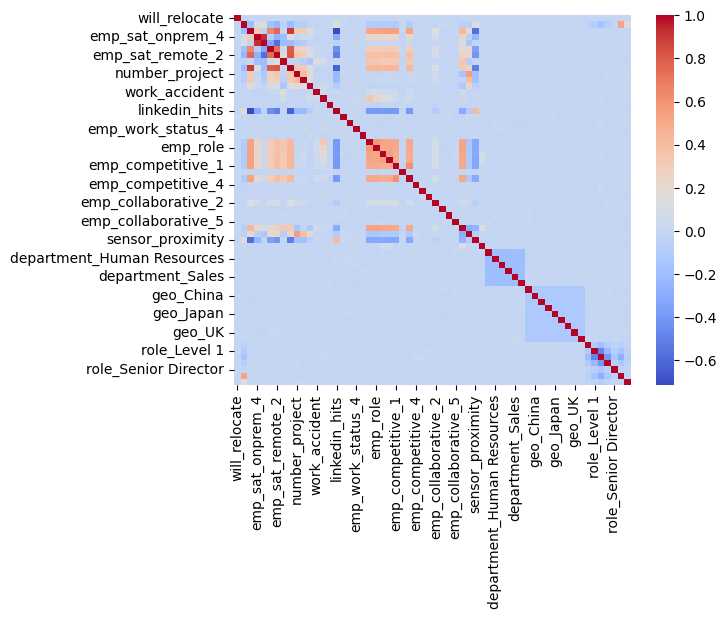

In [30]:
#Compute feature correlation
sns.heatmap(X.corr(), cmap='coolwarm')

# Train test split

In [31]:
# Create a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=10)

In [32]:
#Check shapes
print(f"X_train shape is : {X_train.shape}")
print(f"y_train shape is : {y_train.shape}\n")
print(f"X_test shape is : {X_test.shape}")
print(f"y_test shape is : {y_test.shape}")

X_train shape is : (10499, 60)
y_train shape is : (10499,)

X_test shape is : (4500, 60)
y_test shape is : (4500,)


# Logistic regression

## Fitting step

In [33]:
# Instanciate the logistic regression model
log_reg_mdl = LogisticRegression()

#Fitting the model to train set (features and target)
log_reg_mdl.fit(X_train, y_train)

LogisticRegression()

## Evaluation

### Quick score : Mean accuracy

In [34]:
#Score on train set
log_reg_mdl.score(X_train,y_train)

1.0

In [35]:
#Score on test set
log_reg_mdl.score(X_test,y_test)

1.0

### Cross validation score : Precision

In [36]:
cv_results = cross_validate(log_reg_mdl,
                            X_train, 
                            y_train, 
                            cv=5, 
                            scoring=['precision'])

score = cv_results['test_precision'].mean()
score

1.0

In [37]:
log_reg_mdl.score(X_test,y_test)

1.0

In [38]:
# np.linspace()

In [39]:
# import numpy as np
# from sklearn.model_selection import learning_curve

# train_sizes = [25,50,75,100,250,500,750,1000,1150]

# # Get train scores, train sizes, and validation scores using `learning_curve`
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=LogisticRegression(), X=X, y=y, train_sizes=train_sizes, cv=5)

# # Take the mean of cross-validated train scores and validation scores
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

# #plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# #plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# #plt.ylabel('r2 score', fontsize = 14)
# #plt.xlabel('Training set size', fontsize = 14)
# #plt.title('Learning curves', fontsize = 18, y = 1.03)
# #plt.legend()


# Feature selection : Feature importance based on mean decrease in impurity

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity

In [40]:
# Fitting step
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [41]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.009 seconds


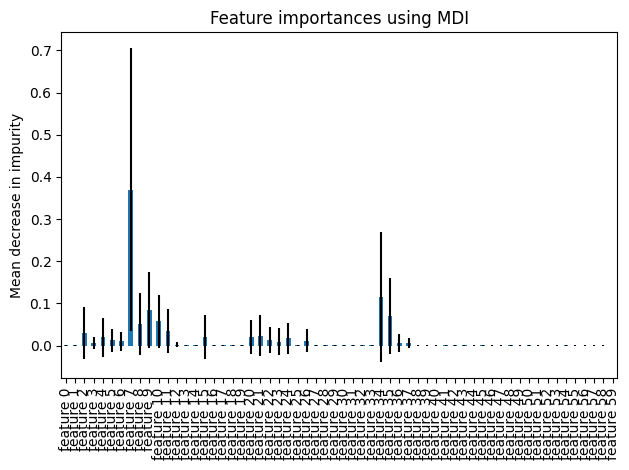

In [42]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [43]:
# Best ranking features
ranking = pd.DataFrame(
                 {"MDI" : forest_importances.values, 
                "X_columns" : X.columns} ,   
                index = forest_importances.index)
    
best_ranking = ranking.sort_values('MDI', ascending=False).head(10)
best_ranking

,MDI,X_columns
feature 7,0.369834,emp_engagement_1
feature 34,0.115541,sensor_stepcount
feature 9,0.084125,number_project
feature 35,0.070118,sensor_heartbeat
feature 10,0.057340,average_montly_hours
feature 8,0.050526,last_evaluation
feature 11,0.033687,time_spend_company
feature 2,0.030236,percent_remote
feature 21,0.023310,emp_role
feature 20,0.020582,emp_identity


In [44]:
new_set_feat = best_ranking.loc[:, 'X_columns'].values.tolist()

# Define X_train_new

In [45]:
X_train_new = X_train[new_set_feat]
check_shape_head(X_train_new)

(10499, 10)


,emp_engagement_1,sensor_stepcount,number_project,sensor_heartbeat,average_montly_hours,last_evaluation,time_spend_company,percent_remote,emp_role,emp_identity
7380,5,0.598533,0.4,0.433333,0.313084,0.546875,5.0,0.8,4,5
8703,5,0.623733,0.2,0.666667,0.635514,0.640625,-1.0,0.8,2,2


In [46]:
X_test_new = X_test[new_set_feat]
check_shape_head(X_test_new)

(4500, 10)


,emp_engagement_1,sensor_stepcount,number_project,sensor_heartbeat,average_montly_hours,last_evaluation,time_spend_company,percent_remote,emp_role,emp_identity
13982,5,0.619333,0.6,0.633333,0.495327,0.953125,-1.0,0.8,2,3
822,1,0.103867,0.0,0.333333,0.228972,0.171875,0.0,0.4,2,2


In [47]:
# Instanciate the logistic regression model
log_reg_mdl = LogisticRegression()

#Fitting the model to train set (features and target)
log_reg_mdl.fit(X_train_new, y_train)

LogisticRegression()

### Quick score : Mean accuracy

In [48]:
#Score on train set
log_reg_mdl.score(X_train_new,y_train)

1.0

In [49]:
#Score on test set
log_reg_mdl.score(X_test_new,y_test)

1.0

### Cross validation score : Precision

In [50]:
cv_results = cross_validate(log_reg_mdl,
                            X_train_new, 
                            y_train, 
                            cv=5, 
                            scoring=['precision'])

score = cv_results['test_precision'].mean()
score

1.0